In [26]:
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sb
import numpy as np
from matplotlib import rcParams
import pymc3 as pm
from IPython.core.display import display, HTML
import theano.tensor as tt
import warnings
% matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
display(HTML("<style>.container {width:90% !important;}</style>"))

In [4]:
dfHu12 = pd.read_pickle('/accounts/ekarakoy/DATA/NOMAD/dfSwfHuOcxCI_2012.pkl')

In [5]:
dfHu12.head(2)

,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,id,depth,hplc_chl,sst,lat,lon
364,0.000719,0.000948,0.001301,0.001324,0.001442,0.000172,7733,4579.0,0.762,28.01,9.8309,-54.0398
365,0.000668,0.000919,0.001278,0.001336,0.001442,0.000148,7734,4711.0,0.653,26.86,13.0033,-55.9705


In [6]:
dfHu12['mxBl'] = dfHu12[['rrs443', 'rrs489', 'rrs510']].max(axis=1)

In [7]:
dfHu12.describe()

,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,id,depth,hplc_chl,sst,lat,lon,mxBl
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,0.005336,0.004684,0.004071,0.003217,0.002535,0.000594,6240.088235,2155.500000,1.942732,21.763382,12.399556,-72.949479,0.005152
std,0.005361,0.003904,0.002099,0.001401,0.001920,0.001094,1922.935381,2018.518092,6.550881,6.950208,25.752077,52.987492,0.003649
min,0.000051,0.000190,0.000422,0.000497,0.000639,0.000000,2640.000000,31.000000,0.017000,5.260000,-35.164400,-170.045000,0.000497
25%,0.001404,0.001766,0.002409,0.002365,0.001568,0.000094,5903.750000,64.000000,0.145750,16.380000,-1.261000,-90.375800,0.002518
50%,0.002839,0.002850,0.003435,0.003235,0.001857,0.000175,7226.500000,2809.500000,0.451500,25.625000,11.413400,-73.367600,0.003624
75%,0.007855,0.007016,0.005809,0.003892,0.002625,0.000503,7314.000000,4305.750000,1.130750,27.290000,37.357600,-56.020225,0.007459
max,0.022010,0.016246,0.009500,0.009600,0.012200,0.007900,7747.000000,5526.000000,53.002700,30.180000,43.619200,170.000000,0.016246


In [8]:
dfHu12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 364 to 4201
Data columns (total 13 columns):
rrs411      136 non-null float64
rrs443      136 non-null float64
rrs489      136 non-null float64
rrs510      136 non-null float64
rrs555      136 non-null float64
rrs670      136 non-null float64
id          136 non-null int32
depth       136 non-null float64
hplc_chl    136 non-null float64
sst         136 non-null float64
lat         136 non-null float64
lon         136 non-null float64
mxBl        136 non-null float64
dtypes: float64(12), int32(1)
memory usage: 14.3 KB


In [9]:
dfStep2 = pd.DataFrame(columns=['mxBl2Gr', 'CI', 'chl'])
dfStep2['mxBl2Gr'] = dfHu12.mxBl / dfHu12.rrs555
dfStep2['CI'] = dfHu12.rrs555 - ( dfHu12.rrs443 + (555 - 443) / ( 670 - 443 ) * ( dfHu12.rrs670 - dfHu12.rrs443 ) )
dfStep2['chl'] = dfHu12.hplc_chl

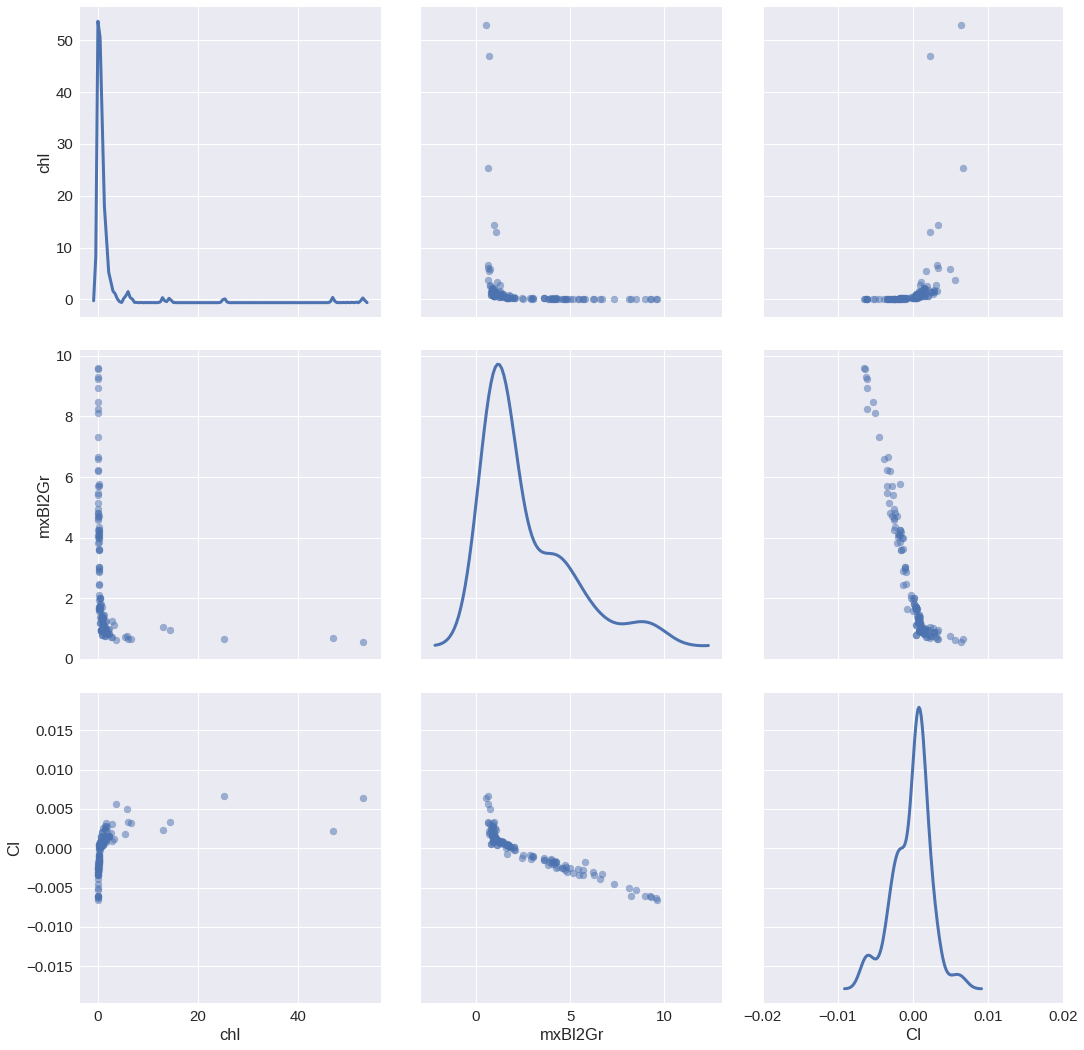

In [10]:
sb.set(font_scale = 1.5)
g = sb.PairGrid(dfStep2, vars=['chl', 'mxBl2Gr', 'CI'], size=5, diag_sharey=False);
g = g.map_upper(pl.scatter, alpha=0.5)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(pl.scatter, alpha=0.5);

In [12]:
dfLogStep2 = pd.DataFrame(columns=['mxBl2Gr', 'CI', 'chl'])
dfLogStep2[['mxBl2Gr','chl']] = np.log10(dfStep2[['mxBl2Gr','chl']])
dfLogStep2.CI = dfStep2.CI

In [13]:
dfLogStep2.describe()

,mxBl2Gr,CI,chl
count,136.000000,136.000000,136.000000
mean,0.273448,-0.000131,-0.342740
std,0.344352,0.002477,0.674366
min,-0.263255,-0.006578,-1.769551
25%,-0.022887,-0.001736,-0.836440
50%,0.176515,0.000470,-0.345349
75%,0.607095,0.001142,0.053355
max,0.982648,0.006631,1.724298


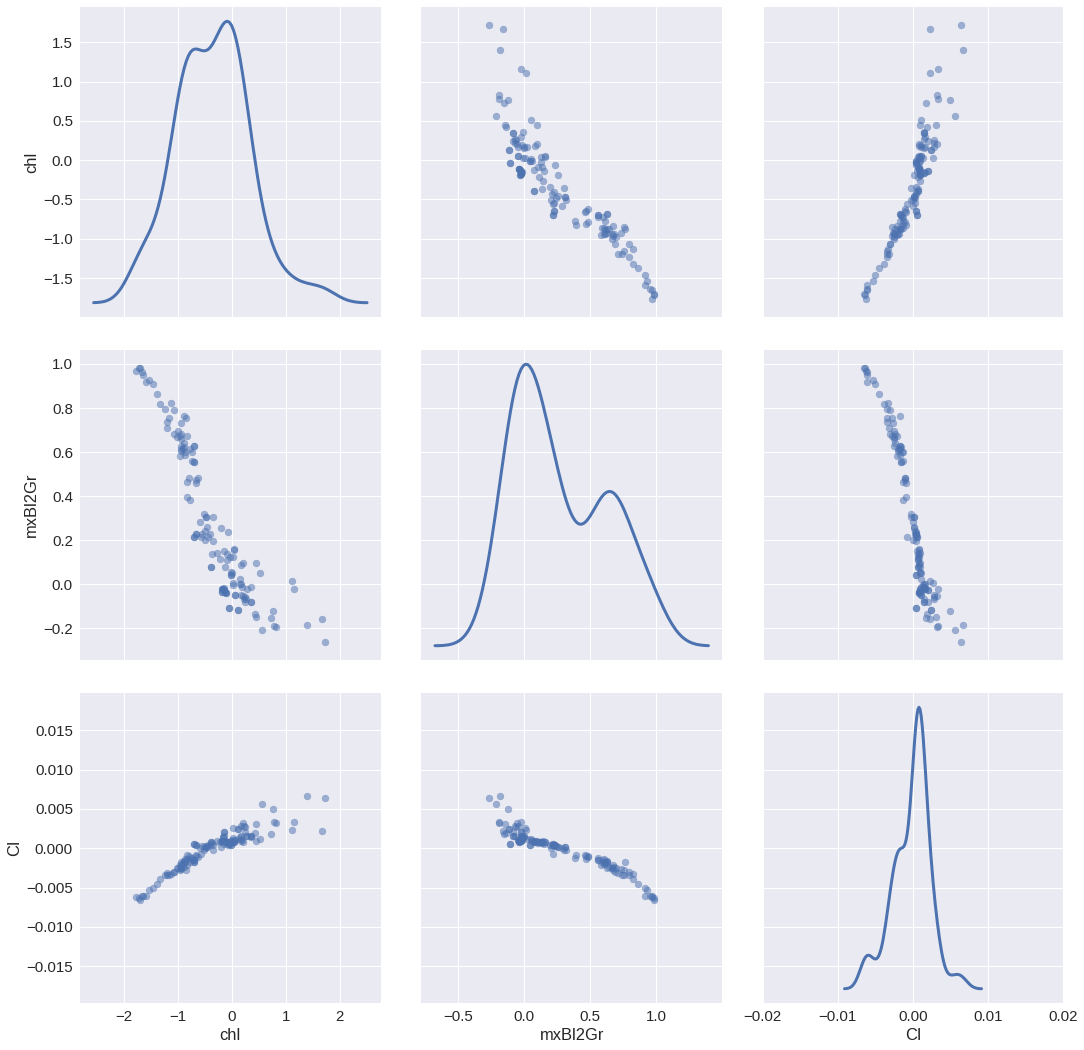

In [14]:
sb.set(font_scale = 1.5)
g = sb.PairGrid(dfLogStep2, vars=['chl', 'mxBl2Gr', 'CI'], size=5, diag_sharey=False);
g = g.map_upper(pl.scatter, alpha=0.5)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(pl.scatter, alpha=0.5);

In [16]:
ocX_train = dfLogStep2.mxBl2Gr.values
ciX_train = dfLogStep2.CI.values
y_train = dfLogStep2.chl.values

In [25]:

with pm.Model() as mdlOCxCI:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, shape=)
    ocx_a0 = pm.Normal('ocx_a0', mu=0, sd=10)
    ocx_a1 = pm.Normal('ocx_a1', mu=0, sd=10)
    ocx_a2 = pm.Normal('ocx_a2', mu=0, sd=10)
    ocx_a3 = pm.Normal('ocx_a3', mu=0, sd=10)
    ocx_a4 = pm.Normal('ocx_a4', mu=0, sd=10)
    ci_a0 = pm.Normal('ci_a0', mu=0, sd=10)
    ci_a1 = pm.Normal('ci_a1')
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu_ocx = ocx_a0 + ocx_a1 * ocX_train + ocx_a2 * ocX_train**2 + ocx_a3 * ocX_train**3 + ocx_a4 * ocX_train**4
    
    mu_ci = ci_a0 + ci_a1 * ocX_train
    mu_ = pm.math.switch(ciSwPntIdx>idx, mu_ocx, mu_ci)
    chlPred = pm.Normal('chlPred', mu=mu_, sd=epsilon, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    traceOCx_norm = pm.sample(10000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval_ to model.
Applied interval-transform to ciSwPntIdx and added transformed ciSwPntIdx_interval_ to model.

  0%|          | 5/10000 [00:03<2:19:29,  1.19it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/accounts/ekarakoy/anaconda3/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/accounts/ekarakoy/anaconda3/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/accounts/ekarakoy/anaconda3/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  0%|          | 7/10000 [02:35<121:55:12, 43.92s/it]
